In [46]:
import numpy as np
import pandas as pd
import pickle
import datetime as dt
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



# suppressing pesky warnings

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

# Visualisation
#import geopandas as gpd
#from geopandas import GeoDataFrame
#from pyproj import CRS
#from shapely.geometry import Point, Polygon

### I will build and compare the following models, then choose one to use on the test set:

- Decision Tree
- Support Vector Regression
- KNearest Neighbors Regression
- Voting Regressor that incorporates above models

The basic procedure for building each model is similar. First, we split the training data 80-20. Each model will test on the 20%, and the model that performs the best on that set will be used on the actual test set.

For each model ,we create set of model parameters to iterate through and find the best set of parameters to fit the 80% training data, determined by lowest RMSE values. We then save those models to a pickle file, using the first three models as inputs to the voting regressor model

In [33]:
train_data = pd.read_csv("provider_train.csv")

X = train_data.iloc[:, 2:]
y = train_data.iloc[:, 1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [34]:
len(x_train), len(y_train), len(x_test), len(y_test), len(train_data)

(4328, 4328, 1082, 1082, 5410)

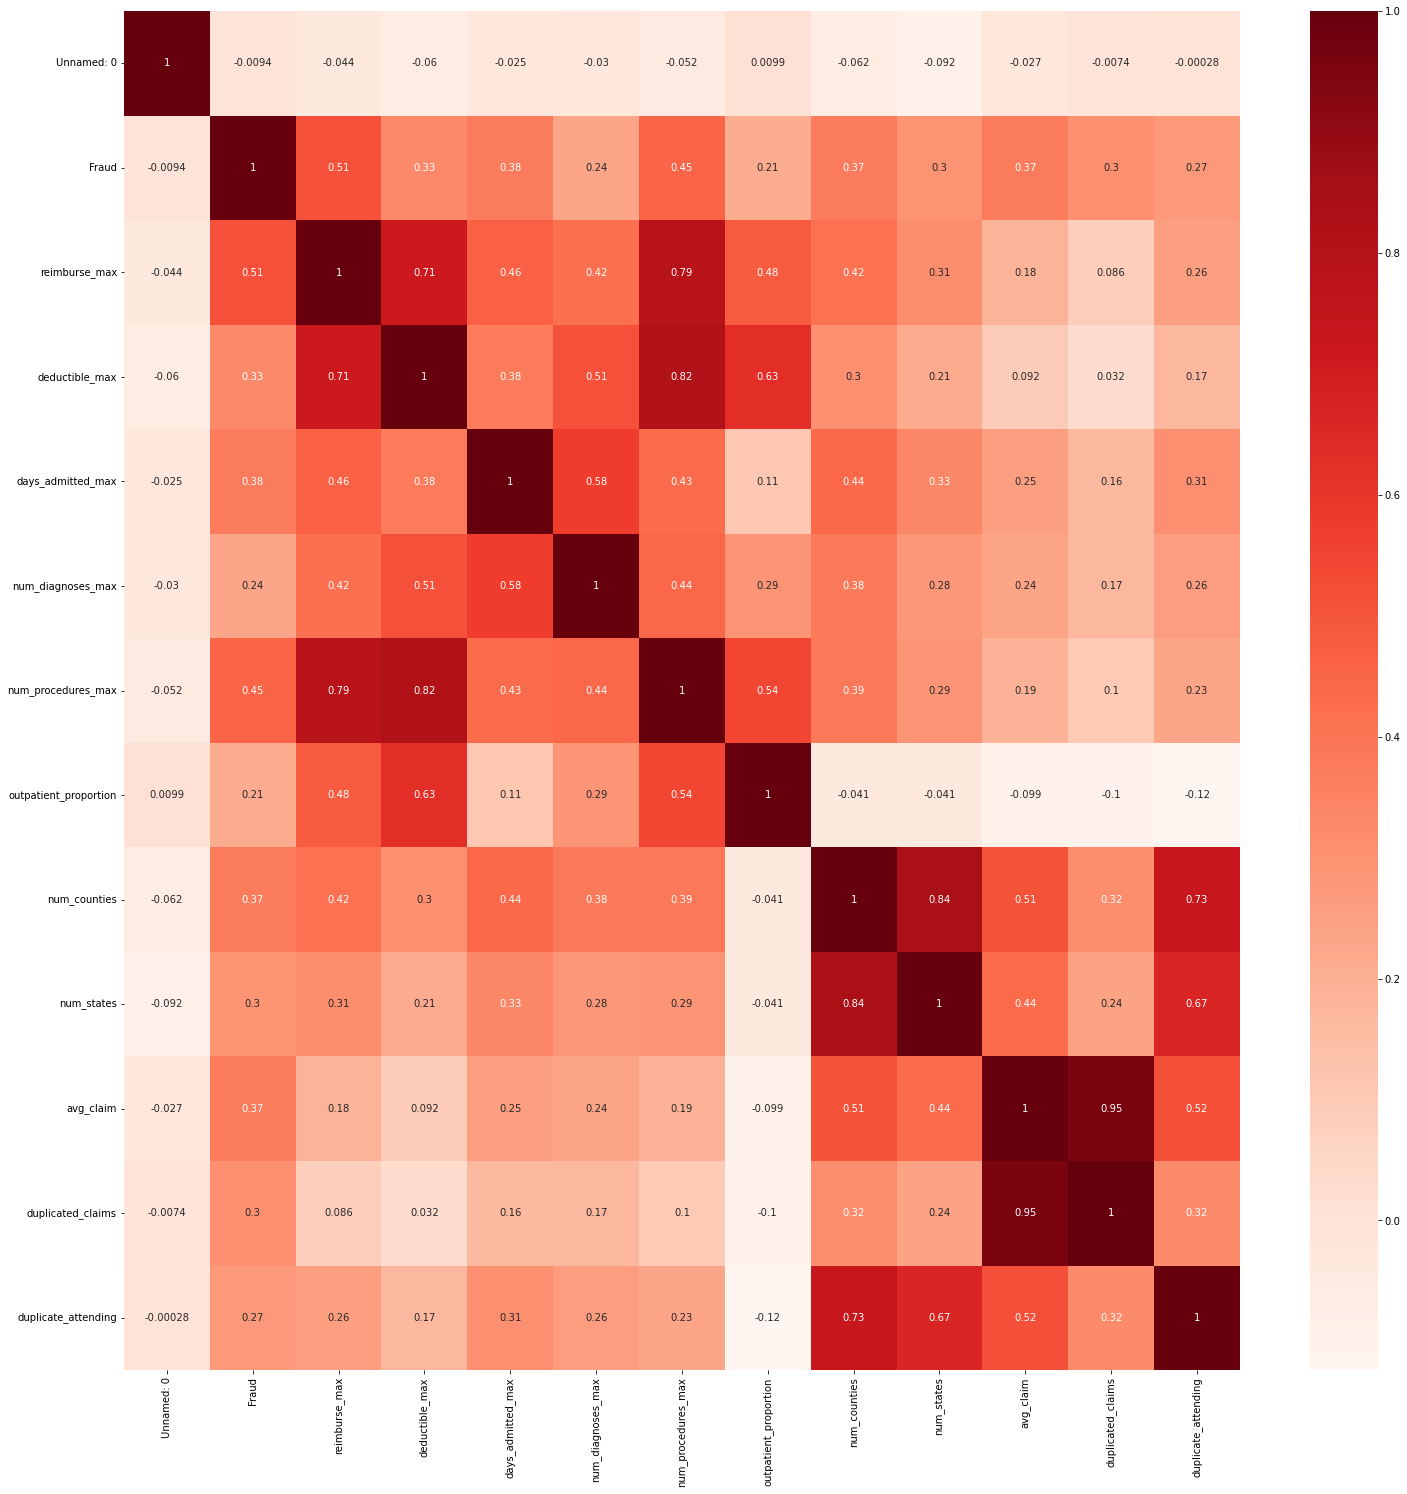

In [35]:
plt.figure(figsize=(25,25))
cor = train_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Model 1: Decision Tree

In [40]:
def createRandomGrid():
    
    criterion = ["gini", "entropy"]
    max_depth = range(1,5)
    min_samples_split = range(1,10)
    min_samples_leaf = range(1,10)
    #min_samples_split = [2, 5, 10, 20]
    #min_samples_leaf = [1, 20, 40, 100]
    
    random_grid = {"criterion": criterion ,
             "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              }
        
    #random_grid = {"criterion": criterion}
    
    return random_grid

def runDecisionTree(random_grid, x_train, y_train):
    
    #rmse_score = make_scorer(rmse, greater_is_better = False)
    
    decision_tree = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(decision_tree, random_grid, cv=10, scoring='accuracy', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runDecisionTree(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("DecisionTreeModel.pkl", 'wb'))

{'criterion': 'gini', 'min_samples_leaf': 8, 'min_samples_split': 2}
0.927910358395347


### Model 2: K-Nearest Neighbors Regression

In [41]:
def createRandomGrid():
    
    n_neighbors = [2,5,10,15]
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan']
    
    random_grid = {'n_neighbors': n_neighbors, 
                   'weights': weights,
                  'metric': metric}

    
    
    return random_grid

def runKNeighbors(random_grid, x_train, y_train):
    
    rmse_score = make_scorer(rmse, greater_is_better = False)
    
    K_neigh = KNeighborsClassifier()
    grid_search = GridSearchCV(K_neigh, random_grid, cv=5, scoring='accuracy', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runKNeighbors(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("KNeighbors.pkl", 'wb'))

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
0.9202859469489647


### Model 3: Random Forest

In [43]:
def createRandomGrid():
    n_estimators = [10 , 50, 100, 200, 400, 500]
    max_features = [6,8,10,12, 14 ]
    max_depth = [2] 
    min_samples_leaf = [1,5,10,25,50]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                   'bootstrap': bootstrap,
                    'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf
                                    }
    
    return random_grid

def runRandomForest(random_grid, x_train, y_train):
    
    forest = RandomForestClassifier(random_state = 42)
    grid_search = GridSearchCV(forest, random_grid, cv=5, scoring='accuracy', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_

param_set = createRandomGrid()
best_model = runRandomForest(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("RandomForestModel.pkl", 'wb'))

{'bootstrap': True, 'max_depth': 2, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 10}
0.9387718431697125


# Model 4: XGBoost

In [49]:
def createRandomGrid():
        
        random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

    
        return random_grid

def runXGB(random_grid, x_train, y_train):
    
    xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
    
    
    
    grid_search = GridSearchCV(xgb, random_grid, cv=5, scoring='accuracy', n_jobs = 4, verbose=3)
    grid_search.fit(x_train, y_train)
    final = grid_search.best_params_
    print(final)
    print(grid_search.best_score_)
    return grid_search.best_estimator_


param_set = createRandomGrid()
best_model = runXGB(param_set, x_train, y_train)
best_model.fit(x_train,y_train)
pickle.dump(best_model, open("XGBModel.pkl", 'wb'))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[14:54:19] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:54:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
0.9422371143654299
[14:54:20] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed dow

### Model 4: Voting Regressor

In [50]:
loaded_rf_model = pickle.load(open("RandomForestModel.pkl", 'rb'))
loaded_kn_model = pickle.load(open("KNeighbors.pkl", 'rb'))
loaded_dt_model = pickle.load(open("DecisionTreeModel.pkl", 'rb'))
loaded_xg_model = pickle.load(open("XGBModel.pkl", 'rb'))


vtr = VotingClassifier([('rf', loaded_rf_model), ('kn', loaded_kn_model), ('dt', loaded_dt_model), ('xg', loaded_xg_model)])
vtr.fit(x_train,y_train)
pickle.dump(vtr, open("VotingClassifierModel.pkl", 'wb'))

[15:02:45] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:02:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
rf_model = pickle.load(open("RandomForestModel.pkl", 'rb'))
kn_model = pickle.load(open("KNeighbors.pkl", 'rb'))
dt_model = pickle.load(open("DecisionTreeModel.pkl", 'rb'))
vtr_model = pickle.load(open("VotingClassifierModel.pkl", 'rb'))
xg_model = pickle.load(open("XGBModel.pkl", 'rb'))

#x_train = pickle.load(open("SplitTrainX_V2.pkl", 'rb'))
#x_test = pickle.load(open("SplitTestX_V2.pkl", 'rb'))
#y_train = pickle.load(open("SplitTrainY_V2.pkl", 'rb'))
#y_test = pickle.load(open("SplitTestY_V2.pkl", 'rb'))

In [ ]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better = False)
features = x_train.columns

In [ ]:
model_list = [rf_model, kn_model, dt_model, vtr_model,xg_model]
model_names = ["RandomForest", "KNearestNeighbors", "DecisionTree", "VotingClassifier", "XGBoost"]
rmse_list = []
results_df_list = []
for i in range(5):
    model = model_list[i]
    model_name = model_names[i]
    y_test_predictions =  model.predict(x_test)
    y_train_predictions = model.predict(x_train)

    rmse_test = math.sqrt(mean_squared_error(y_test, y_test_predictions))
    rmse_train = math.sqrt(mean_squared_error(y_train, y_train_predictions))
    cv_scores = -cross_val_score(model, x_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_cv = math.sqrt(cv_scores.mean())

    rmse_list.append([model_name,rmse_test,rmse_train,rmse_cv])
    
    y_test = np.array(list(y_test))
    y_test_predictions = np.array(y_test_predictions)
    dfi = pd.DataFrame({'Actual IR': y_test, 'Predicted IR': y_test_predictions})
    results_df_list.append(df)

In [ ]:
rmse_df = pd.DataFrame(rmse_list, columns = ["Model Name", "Test RMSE", "Train RMSE", "CV RMSE"])
rmse_df.sort_values(by=['Test RMSE'])